# Abstract


## Dataset Overview
- **Data Source**: [Kaggle - Food Nutrition Dataset](https://www.kaggle.com/datasets/shrutisaxena/food-nutrition-dataset?resource=download&select=food.csv)
- **Number of Records**: 7,413



In [256]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [257]:
#Reading the file into a dataframe and viewing the first few rows
df = pd.read_csv('food.csv')
df.head()

,Category,Description,Nutrient Data Bank Number,Data.Alpha Carotene,Data.Ash,Data.Beta Carotene,Data.Beta Cryptoxanthin,Data.Carbohydrate,Data.Cholesterol,Data.Choline,...,Data.Major Minerals.Potassium,Data.Major Minerals.Sodium,Data.Major Minerals.Zinc,Data.Vitamins.Vitamin A - IU,Data.Vitamins.Vitamin A - RAE,Data.Vitamins.Vitamin B12,Data.Vitamins.Vitamin B6,Data.Vitamins.Vitamin C,Data.Vitamins.Vitamin E,Data.Vitamins.Vitamin K
0,BUTTER,"BUTTER,WITH SALT",1001,0,2.11,158,0,0.06,215,19,...,24,576,0.09,2499,684,0.17,0.003,0.0,2.32,7.0
1,BUTTER,"BUTTER,WHIPPED,WITH SALT",1002,0,2.11,158,0,0.06,219,19,...,26,827,0.05,2499,684,0.13,0.003,0.0,2.32,7.0
2,BUTTER OIL,"BUTTER OIL,ANHYDROUS",1003,0,0.00,193,0,0.00,256,22,...,5,2,0.01,3069,840,0.01,0.001,0.0,2.80,8.6
3,CHEESE,"CHEESE,BLUE",1004,0,5.11,74,0,2.34,75,15,...,256,1395,2.66,763,198,1.22,0.166,0.0,0.25,2.4
4,CHEESE,"CHEESE,BRICK",1005,0,3.18,76,0,2.79,94,15,...,136,560,2.60,1080,292,1.26,0.065,0.0,0.26,2.5


In [258]:
#wget from github https://github.com/vraosharma-northeastern/exploratory-data-analysis/blob/main/Nutrition%20/food.csv
!wget https://raw.githubusercontent.com/vraosharma-northeastern/exploratory-data-analysis/main/Nutrition%20/food.csv

zsh:1: command not found: wget


In [259]:
#Viewing last few rows in file
df.tail()

,Category,Description,Nutrient Data Bank Number,Data.Alpha Carotene,Data.Ash,Data.Beta Carotene,Data.Beta Cryptoxanthin,Data.Carbohydrate,Data.Cholesterol,Data.Choline,...,Data.Major Minerals.Potassium,Data.Major Minerals.Sodium,Data.Major Minerals.Zinc,Data.Vitamins.Vitamin A - IU,Data.Vitamins.Vitamin A - RAE,Data.Vitamins.Vitamin B12,Data.Vitamins.Vitamin B6,Data.Vitamins.Vitamin C,Data.Vitamins.Vitamin E,Data.Vitamins.Vitamin K
7408,FROG LEGS,"FROG LEGS,RAW",80200,0,1.40,0,0,0.0,50,65,...,285,58,1.0,50,15,0.4,0.12,0.0,1.00,0.1
7409,MACKEREL,"MACKEREL,SALTED",83110,0,13.40,0,0,0.0,95,95,...,520,4450,1.1,157,47,12.0,0.41,0.0,2.38,7.8
7410,SCALLOP,"SCALLOP,(BAY&SEA),CKD,STMD",90240,0,3.06,0,0,0.0,53,81,...,476,265,3.0,100,30,1.3,0.10,0.0,1.50,0.2
7411,SNAIL,"SNAIL,RAW",90560,0,1.30,0,0,2.0,50,65,...,382,70,1.0,100,30,0.5,0.13,0.0,5.00,0.1
7412,TURTLE,"TURTLE,GREEN,RAW",93600,0,1.20,0,0,0.0,50,65,...,230,68,1.0,100,30,1.0,0.12,0.0,0.50,0.1


## Dataset Drilldown & Cleanup
Each row represents a food type; the *Description* column contains a breakdown of the few ingredients that comprise the dish or food as well as details of how it was prepared. There are many flaws with this dataset that need to be addressed before we can begin our analysis.

In [260]:
#Show the columns and data types in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7413 entries, 0 to 7412
Data columns (total 48 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Category                                                 7413 non-null   object 
 1   Description                                              7413 non-null   object 
 2   Nutrient Data Bank Number                                7413 non-null   int64  
 3   Data.Alpha Carotene                                      7413 non-null   int64  
 4   Data.Ash                                                 7413 non-null   float64
 5   Data.Beta Carotene                                       7413 non-null   int64  
 6   Data.Beta Cryptoxanthin                                  7413 non-null   int64  
 7   Data.Carbohydrate                                        7413 non-null   float64
 8   Data.Cholesterol            

In [261]:
# Loop through columns and remove redundant 'Data.' tag from column names
for col in df.columns:
    new_col = col.replace('Data.', '')  # Remove 'Data.' from the column name
    df.rename(columns={col: new_col}, inplace=True)  # Rename the column name in dataframe

In [262]:
# Find percentage of null values and sort by missing %
df.isnull().sum().sort_values(ascending=False) / len(df) * 100

Household Weights.2nd Household Weight Description    41.818427
Household Weights.1st Household Weight Description     6.340213
Category                                               0.000000
Description                                            0.000000
Fat.Polysaturated Fat                                  0.000000
Fat.Saturated Fat                                      0.000000
Fat.Total Lipid                                        0.000000
Household Weights.1st Household Weight                 0.000000
Household Weights.2nd Household Weight                 0.000000
Major Minerals.Calcium                                 0.000000
Major Minerals.Copper                                  0.000000
Major Minerals.Iron                                    0.000000
Major Minerals.Magnesium                               0.000000
Major Minerals.Phosphorus                              0.000000
Major Minerals.Potassium                               0.000000
Major Minerals.Sodium                   

As we can see, there are null values in the 'Household Weight Description' columns. Because *2nd Household Weight* and *2nd Household Weight Description* are the same measure expressed in different units and has more nulls, we can drop the two columns.


In [263]:
# Drop 'Household Weight Description' columns
df.drop(['Household Weights.2nd Household Weight Description', 'Household Weights.2nd Household Weight'], axis=1, inplace=True)

Despite having only non-null values, both categorical and numeric attributes of this dataset have a few "placeholder" values. Let's quantify these.


In [264]:
# Find the number of values in the 'Category' column that ci match '%no category%'
df[df['Category'].str.contains('no category', case=False)]['Category'].count()/ len(df)

0.026709834075273168

In [265]:
# Show the percentage of 0s in each numeric column of the dataset
df.select_dtypes(include=['float64', 'int64']).apply(lambda x: x[x == 0].count() / len(df)).sort_values(ascending=False)

Lycopene                                  0.966275
Beta Cryptoxanthin                        0.920005
Alpha Carotene                            0.918117
Refuse Percentage                         0.804667
Lutein and Zeaxanthin                     0.788075
Beta Carotene                             0.739512
Retinol                                   0.716444
Vitamins.Vitamin K                        0.571024
Choline                                   0.547552
Vitamins.Vitamin A - RAE                  0.508701
Vitamins.Vitamin C                        0.505733
Vitamins.Vitamin B12                      0.499933
Sugar Total                               0.482800
Cholesterol                               0.476190
Fiber                                     0.461082
Vitamins.Vitamin E                        0.458249
Vitamins.Vitamin A - IU                   0.362067
Manganese                                 0.244975
Selenium                                  0.242277
Pantothenic Acid               

We can see that the *Category* column has less than 3% of its values labeled 'no category'. This is not a significant amount of data, but any pattern found using these records would not be actionable. Let's remove these rows from our dataset.

Because we're dealing with a variety of foods, it makes sense that certain nutrients would be absent. However, all foods should have a Weight (g) greater than 0. We will remove all rows where the Weight (g) is 0. Knowing the weight of two similar foods is crucial to understand relative nutritional value.

In [266]:
# Drop rows where *Household Weights.1st Household Weight* is 0
df = df[df['Household Weights.1st Household Weight'] != 0]

# Drop rows where *Category* is 'no category'
df = df[~df['Category'].str.contains('no category', case=False)]

Finally, let's limit the scope of our dataset to exclude information that gives is found in small quantities in food. We will remove the following columns to simplify our analysis:
1. **Alpha Carotene**
2. **Beta Carotene**
3. **Beta Cryptoxanthin**
4. **Lycopene**
5. **Lutein and Zeaxanthin**
6. **Retinol**
7. **Riboflavin**
8. **Selinium**
9. **Thiamin**
10. **Choline**
11. **Manganese**
12. **Niacin**
13. **Pantothenic Acid**

In [267]:
# Drop columns that are not relevant to our analysis
df.drop(['Alpha Carotene', 'Beta Carotene', 'Beta Cryptoxanthin', 'Lycopene', 'Lutein and Zeaxanthin', 'Retinol', 'Riboflavin', 'Selenium', 'Thiamin', 'Choline', 'Manganese', 'Niacin', 'Pantothenic Acid'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6757 entries, 0 to 7409
Data columns (total 33 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Category                                            6757 non-null   object 
 1   Description                                         6757 non-null   object 
 2   Nutrient Data Bank Number                           6757 non-null   int64  
 3   Ash                                                 6757 non-null   float64
 4   Carbohydrate                                        6757 non-null   float64
 5   Cholesterol                                         6757 non-null   int64  
 6   Fiber                                               6757 non-null   float64
 7   Kilocalories                                        6757 non-null   int64  
 8   Protein                                             6757 non-null   float64
 9

<Figure size 800x500 with 0 Axes>

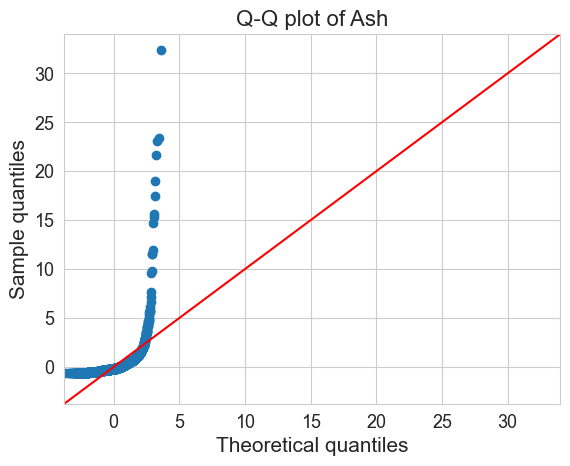

<Figure size 800x500 with 0 Axes>

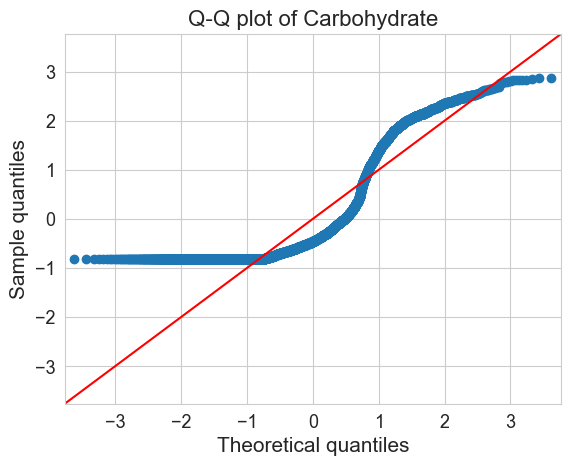

<Figure size 800x500 with 0 Axes>

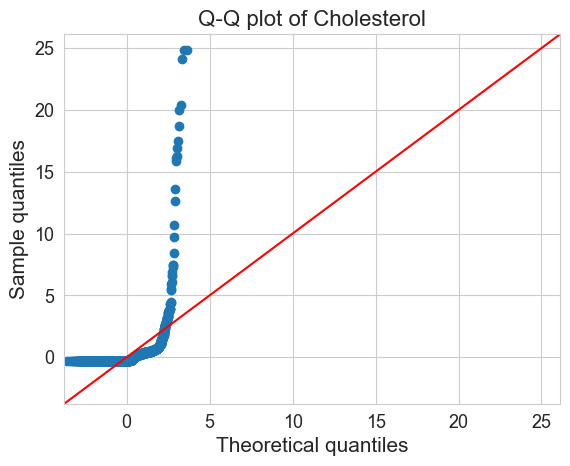

<Figure size 800x500 with 0 Axes>

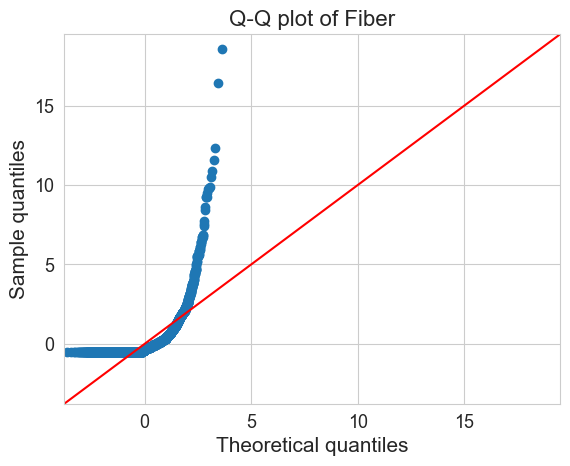

<Figure size 800x500 with 0 Axes>

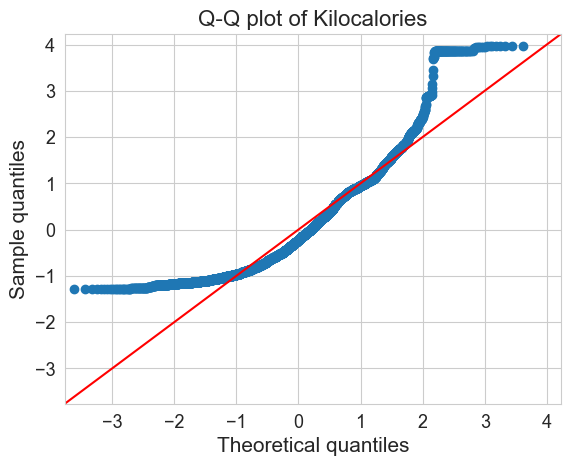

<Figure size 800x500 with 0 Axes>

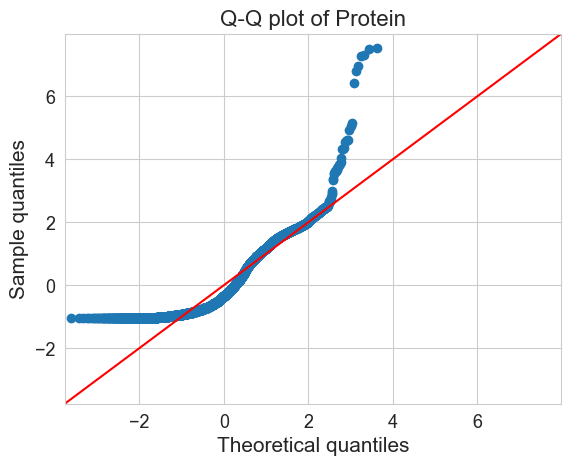

<Figure size 800x500 with 0 Axes>

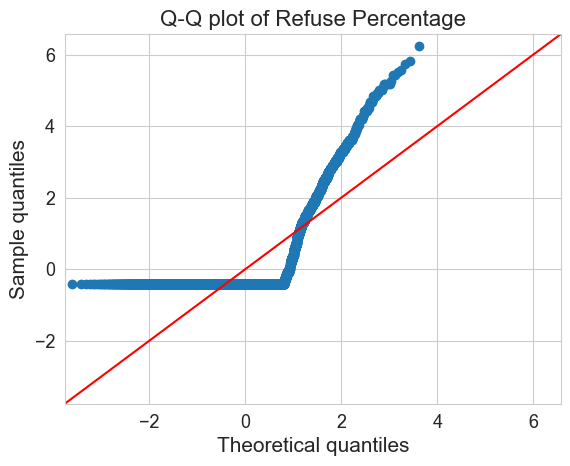

<Figure size 800x500 with 0 Axes>

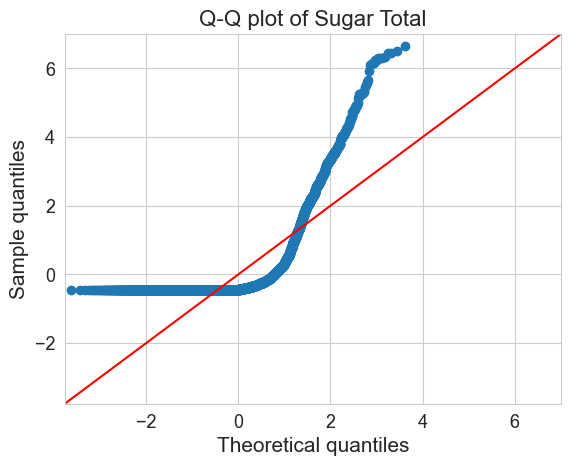

<Figure size 800x500 with 0 Axes>

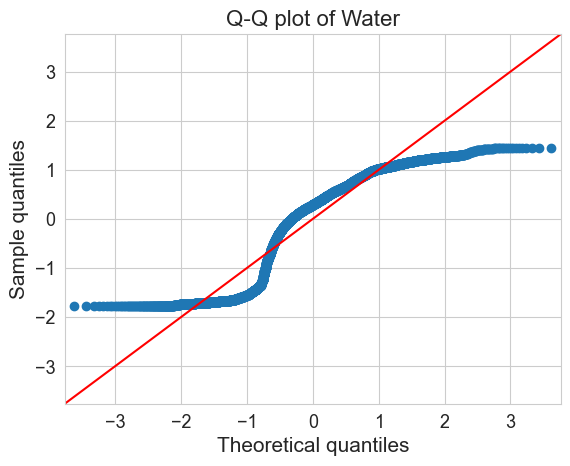

<Figure size 800x500 with 0 Axes>

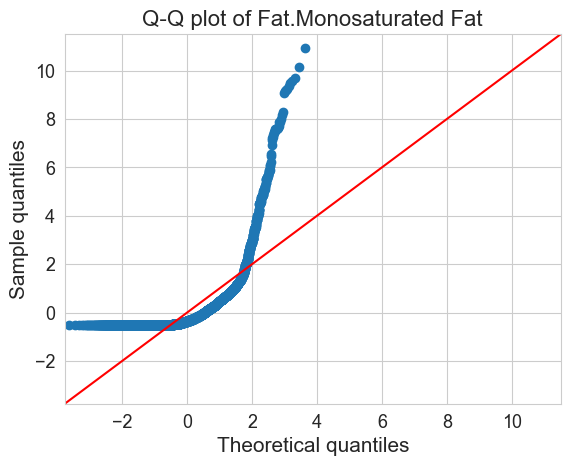

<Figure size 800x500 with 0 Axes>

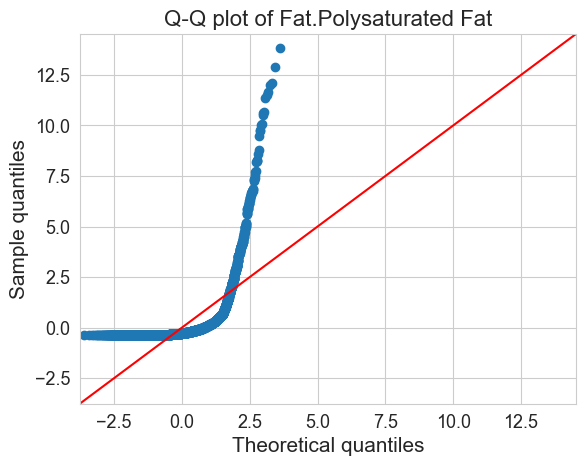

<Figure size 800x500 with 0 Axes>

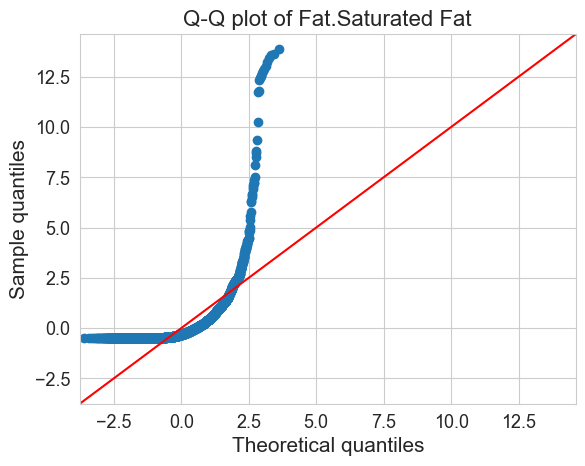

<Figure size 800x500 with 0 Axes>

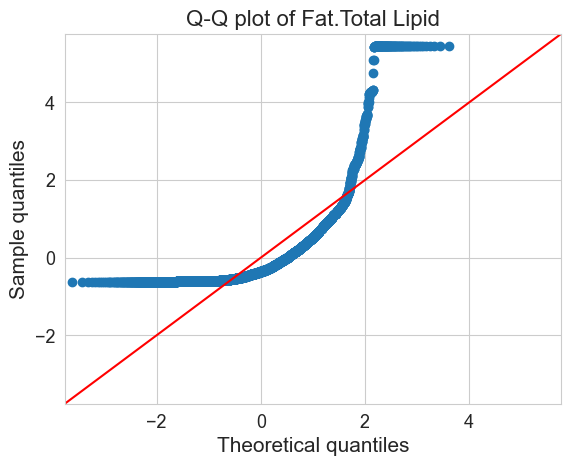

<Figure size 800x500 with 0 Axes>

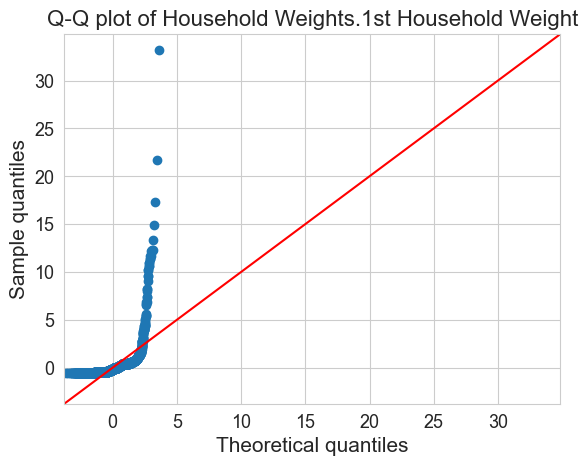

<Figure size 800x500 with 0 Axes>

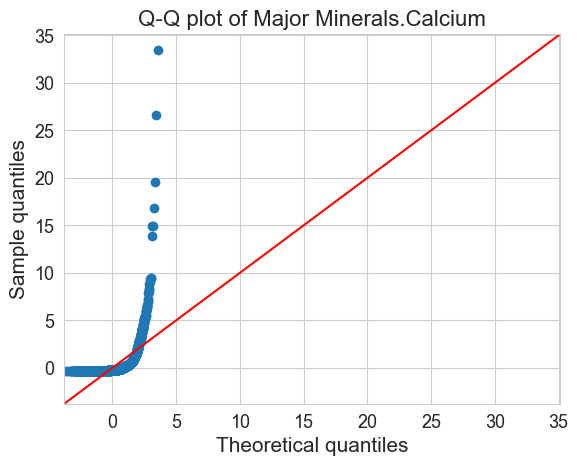

<Figure size 800x500 with 0 Axes>

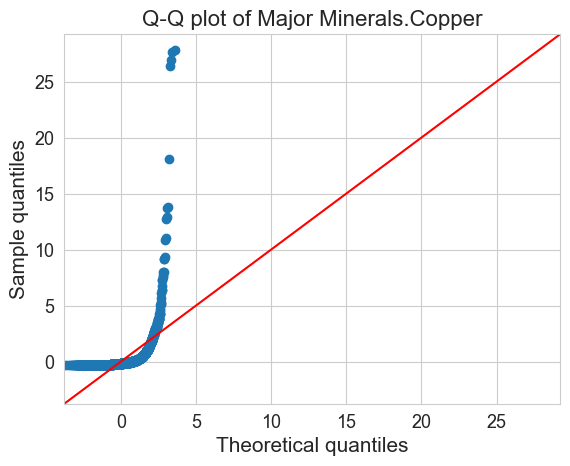

<Figure size 800x500 with 0 Axes>

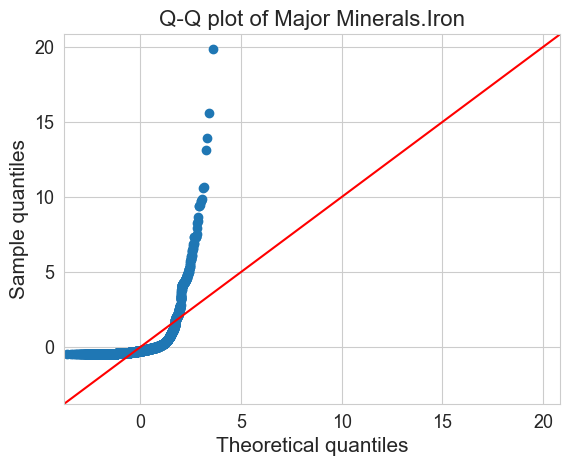

<Figure size 800x500 with 0 Axes>

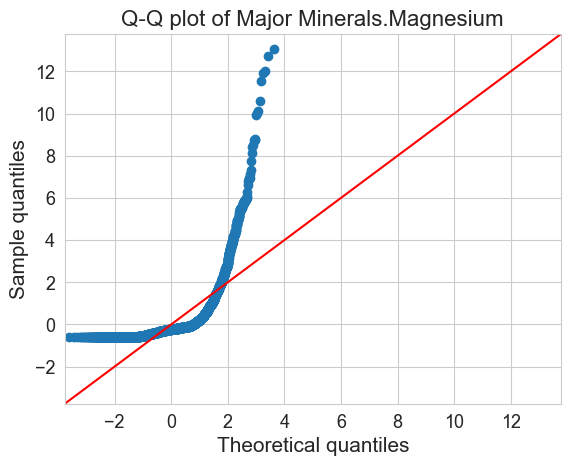

<Figure size 800x500 with 0 Axes>

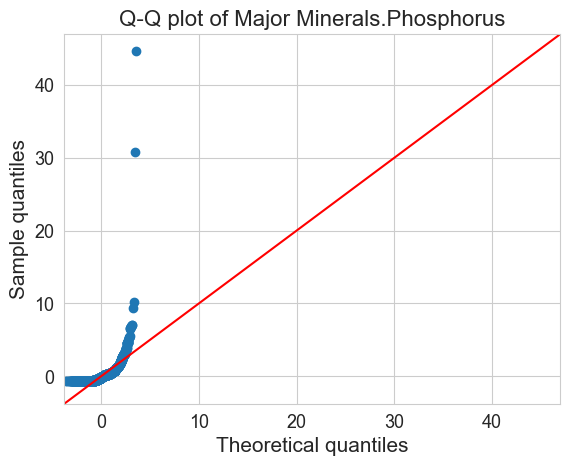

<Figure size 800x500 with 0 Axes>

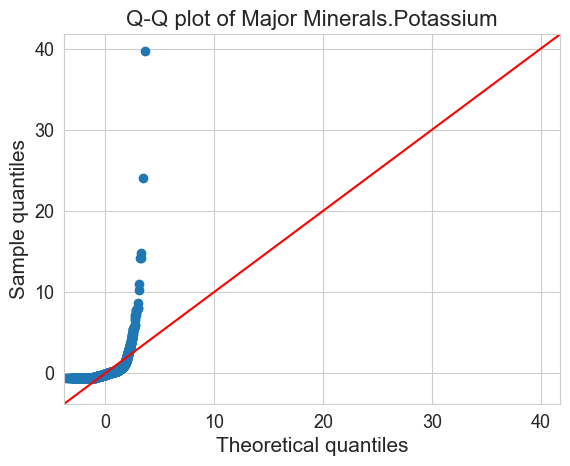

<Figure size 800x500 with 0 Axes>

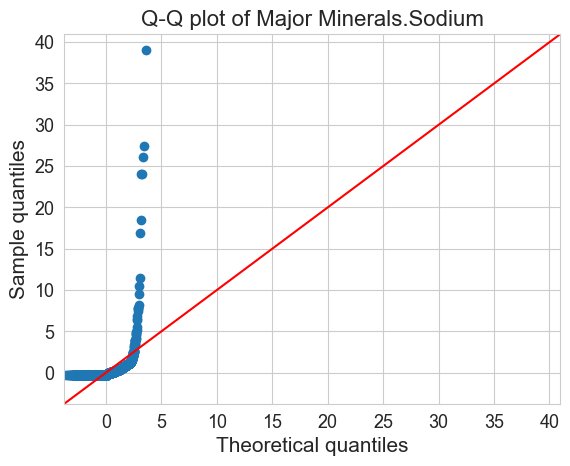

<Figure size 800x500 with 0 Axes>

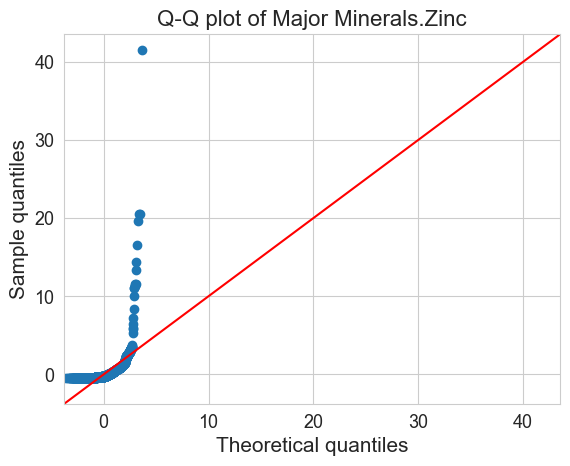

<Figure size 800x500 with 0 Axes>

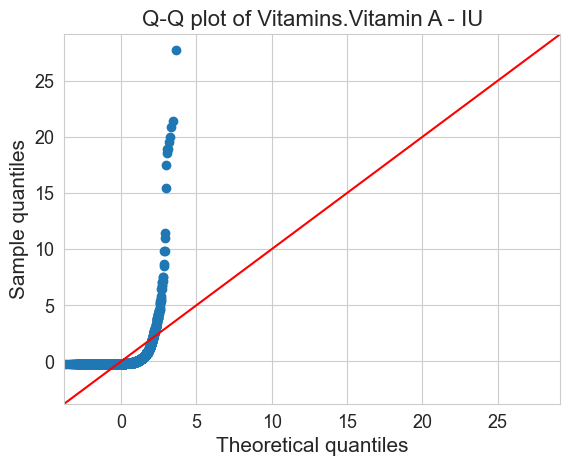

<Figure size 800x500 with 0 Axes>

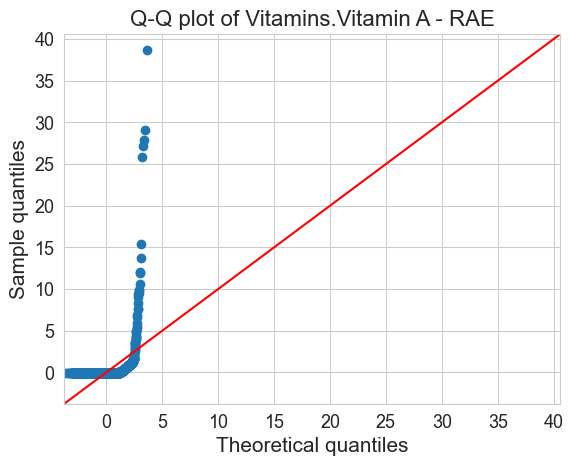

<Figure size 800x500 with 0 Axes>

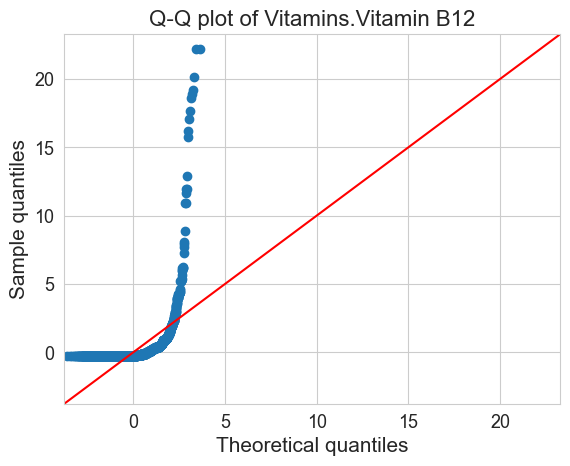

<Figure size 800x500 with 0 Axes>

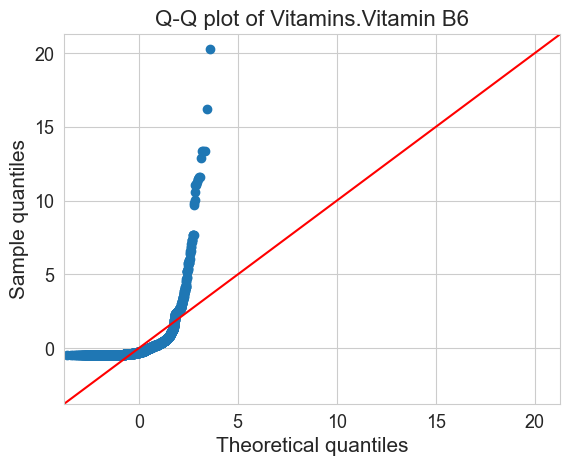

<Figure size 800x500 with 0 Axes>

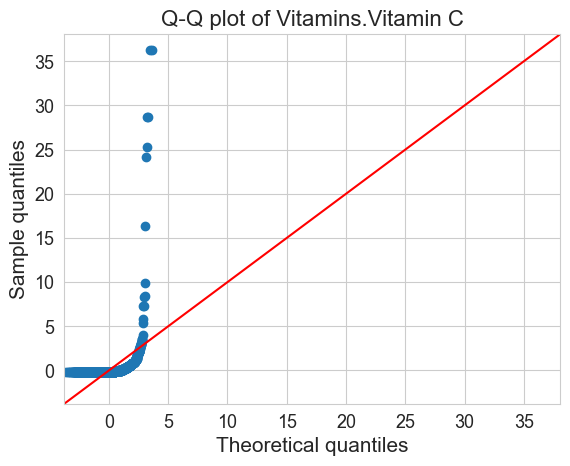

<Figure size 800x500 with 0 Axes>

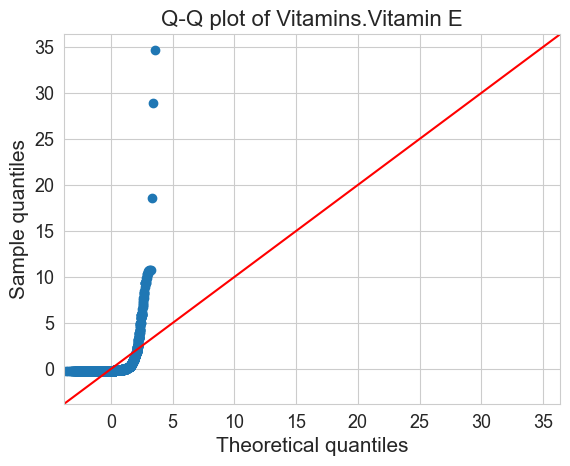

<Figure size 800x500 with 0 Axes>

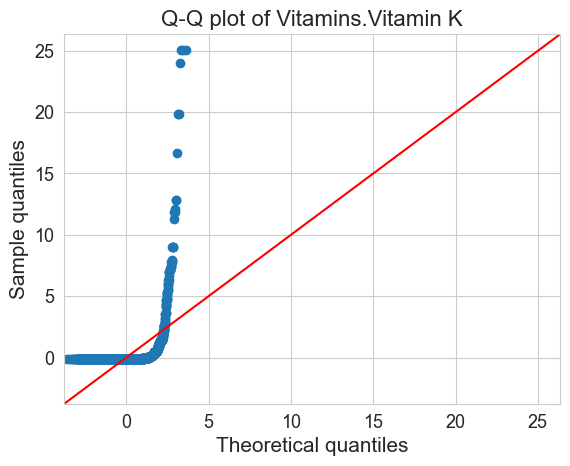

In [268]:
# checking the distribution of independent variables
from statsmodels.graphics.gofplots import qqplot

# Add all numeric columns to a list besides Nutrient Data Bank Number
numeric_cols = df.select_dtypes(include=['float64', 'int64']).drop(['Nutrient Data Bank Number'], axis=1)

for c in numeric_cols.columns[:]:
    plt.figure(figsize=(8, 5))
    fig = qqplot(numeric_cols[c], line="45", fit="True")
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel("Theoretical quantiles", fontsize=15)
    plt.ylabel("Sample quantiles", fontsize=15)
    plt.title("Q-Q plot of {}".format(c), fontsize=16)
    plt.grid(True)
    plt.show()

## References

1. [Kaggle - Food Nutrition Dataset](https://www.kaggle.com/datasets/shrutisaxena/food-nutrition-dataset?resource=download&select=food.csv)
2. https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/ML_Data_Cleaning_and_Feature_Selection/ML_Data_Cleaning_and_Feature_Selection_Abalone.ipynb
3.

## Acknowledgements

I would like to thank [Shruti Saxena](https://www.kaggle.com/shrutisaxena) for sharing this dataset on Kaggle.
